In [65]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt

# Other
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
from noisyopt import minimizeSPSA

import multiprocessing
##############

#   _    
#  / |   
#  | |   
#  | |_  
#  |_(_) 

def qml_build_H(N, lam, J):
    '''
    Set up Hamiltonian: 
            H = lam*Σsigma^i_z - J*Σsigma^i_x*sigma^{i+1}_ 
    '''
    # Interaction of spins with magnetic field
    H = lam * qml.PauliZ(0)
    for i in range(1,N):
        H = H + lam * qml.PauliZ(i)
        
    # Interaction between spins:
    for i in range(0,N-1):
        H = H + J*(-1)*( qml.PauliX(i) @ qml.PauliX(i+1) )
    
    return H

#  ____     
# |___ \    
#   __) |   
#  / __/ _  
# |_____(_) Circuit functions

def circuit_block_1(N, param, shift_invariance = 0, index = 0, p_noise = 0):
    '''
    RX + RY + CNOTS
    
    shift_invariance = 0: Each wire permorms independent rotations.
    shift_invariance = 1: Same rotation for odd and even wires,
                         expect for the first and last that have unique
                         rotation.
    shift_invariance = 2: Same rotation for each wire
    '''
    noise = True
    if p_noise == 0: noise = False # Remove BitFlip and PhaseFlip if we are not using default.mixed
    
    if shift_invariance == 0: # Independent rotations
        # Apply RX and RY to each wire:
        for spin in range(N):
            qml.RY(param[index + spin],     wires = spin)
            if noise: qml.PhaseFlip(p_noise, wires = spin); qml.BitFlip(p_noise, wires = spin)
            qml.RX(param[index + N + spin], wires = spin)
            if noise: qml.PhaseFlip(p_noise, wires = spin); qml.BitFlip(p_noise, wires = spin)
        return index + 2*N
        
    elif shift_invariance == 1: # RX and RY rotations
        # Apply RX + RY for first wire
        qml.RY(param[index + 0], wires = 0)
        if noise: qml.PhaseFlip(p_noise, wires = 0); qml.BitFlip(p_noise, wires = 0)
        qml.RX(param[index + 1], wires = 0)
        if noise: qml.PhaseFlip(p_noise, wires = 0); qml.BitFlip(p_noise, wires = 0)
        
        # Apply RX + RY for last wire
        qml.RY(param[index + 2], wires = N - 1)
        if noise: qml.PhaseFlip(p_noise, wires = N - 1); qml.BitFlip(p_noise, wires = N - 1)
        qml.RX(param[index + 3], wires = N - 1)
        if noise: qml.PhaseFlip(p_noise, wires = N - 1); qml.BitFlip(p_noise, wires = N - 1)

        # Apply RX + RY for even and odd wires
        for spin in range(1,N-1,2):
            qml.RY(param[index + 4], wires = spin)
            qml.RY(param[index + 5], wires = spin+1)
            if noise: 
                qml.PhaseFlip(p_noise, wires = spin); qml.BitFlip(p_noise, wires = spin);
                qml.PhaseFlip(p_noise, wires = spin+1); qml.BitFlip(p_noise, wires = spin+1)
            qml.RX(param[index + 6], wires = spin)
            qml.RX(param[index + 7], wires = spin+1)
            if noise: 
                qml.PhaseFlip(p_noise, wires = spin); qml.BitFlip(p_noise, wires = spin)
                qml.PhaseFlip(p_noise, wires = spin+1); qml.BitFlip(p_noise, wires = spin+1)
        
        return index + 8
    
    elif shift_invariance == 2:
        # Apply same RX and RY to each wire:
        for spin in range(N):
            qml.RY(param[index + 0], wires = spin)
            if noise: qml.PhaseFlip(p_noise, wires = spin); qml.BitFlip(p_noise, wires = spin)
            qml.RX(param[index + 1], wires = spin)
            if noise: qml.PhaseFlip(p_noise, wires = spin); qml.BitFlip(p_noise, wires = spin)
            
        return index + 2
    
    else:
        raise ValueError('Invalid shift_invariance input value')
        
def circuit_block_2(N, param, shift_invariance = 0, index = 0, p_noise = 0):
    '''
    RY
    
    shift_invariance = 0: Each wire permorms independent rotations.
    shift_invariance = 1: Same rotation for odd and even wires,
                         expect for the first and last that have unique
                         rotation.
    shift_invariance = 2: Same rotation for each wire
    '''
    noise = True
    if p_noise == 0: noise = False # Remove BitFlip and PhaseFlip if we are not using default.mixed
    
    if shift_invariance == 0: # Independent rotations
        # Apply RX and RY to each wire:
        for spin in range(N):
            qml.RY(param[index + spin],   wires = spin)
            if noise: qml.PhaseFlip(p_noise, wires = spin); qml.BitFlip(p_noise, wires = spin)
            
    elif shift_invariance == 1: # RX and RY rotations
        # Apply RY for first wire
        qml.RY(param[index + 0], wires = 0)
        if noise: qml.PhaseFlip(p_noise, wires = 0); qml.BitFlip(p_noise, wires = 0)

        # Apply RY for last wire
        qml.RY(param[index + 1], wires = N - 1)
        if noise: qml.PhaseFlip(p_noise, wires = N - 1); qml.BitFlip(p_noise, wires = N - 1)

        # Apply RY for even and odd wires
        for spin in range(1,N-1,2):
            qml.RY(param[index + 2], wires = spin)
            if noise: qml.PhaseFlip(p_noise, wires = spin); qml.BitFlip(p_noise, wires = spin)
            qml.RY(param[index + 3], wires = spin+1)
            if noise: qml.PhaseFlip(p_noise, wires = spin+1); qml.BitFlip(p_noise, wires = spin+1)
        
    elif shift_invariance == 2:
        # Apply same RX and RY to each wire:
        for spin in range(N):
            qml.RY(param[index + 0], wires = spin)
            if noise: qml.PhaseFlip(p_noise, wires = spin); qml.BitFlip(p_noise, wires = spin)
         
    else:
        raise ValueError('Invalid shift_invariance input value')

def circuit_entanglement(N, p_noise_ent = 0):
    # Apply entanglement to the neighbouring spins
    noise = True
    if p_noise_ent == 0: noise = False # Remove BitFlip and PhaseFlip if we are not using default.mixed
    
    for spin in range(0,N-1):
        qml.CNOT(wires = [spin, spin+1])
        if noise: qml.PhaseFlip(p_noise_ent, wires = spin+1); qml.BitFlip(p_noise_ent, wires = spin+1)
          
def circuit(N, params, shift_invariance = 0, p_noise = 0, p_noise_ent = 0):
    index = circuit_block_1(N, params, shift_invariance, p_noise = p_noise)
    circuit_entanglement(N, p_noise_ent)
    qml.Barrier()
    index = circuit_block_1(N, params, shift_invariance, index, p_noise)
    circuit_entanglement(N, p_noise_ent)
    qml.Barrier()
    circuit_block_2(N, params, shift_invariance, index, p_noise)

#  _____   
# |___ /   
#   |_ \   
#  ___) |  
# |____(_) Learning functions

# This function does not use Multiprocessing to parrallelize computations, however it does recycle thetas
def train(step_size, lams, n_epochs, N, J, vqe_cost_fn, shift_invariance = 0, p_noise = 0, p_noise_ent = 0, circuit = False, plots = False, first_epochs = False):
    '''
    step_size    = Step size of the optimizer
    first_epochs = # epochs for first lambda (magnetic field)
    n_epochs     = # epochs for the other lambdas
    lams         = Array of intensities of magnetic field
    N            = Number of spins of the system
    '''
    
    display(Markdown('***Parameters:***'))
    print('step_size    = {0} (Step size of the optimizer)'.format(step_size))
    print('first_epochs = {0} (# epochs for first GS)'.format(first_epochs))
    print('n_epochs     = {0} (# epochs for the other GSs)'.format(n_epochs))
    print('N            = {0} (Number of spins of the system)'.format(N))
    
    # Array of energies for each final ground state found
    vqe_e = []
    errs = np.zeros((n_epochs, len(lams)) )
    
    # Since in order to find the other thetas we start from the optimized parameters of
    # the previous state, to reach a minimum, a less number of parameters is required
    if not first_epochs:
        first_epoch = n_epochs
    
    # Prepare initial state randomly
    if shift_invariance == 0:
        thetas = np.array(np.random.randn(6*N), requires_grad = True)
    elif shift_invariance == 1:
        thetas = np.array(np.random.randn(20),  requires_grad = True)
    elif shift_invariance == 2:
        thetas = np.array(np.random.randn(5),   requires_grad = True)
        
    if circuit:
        # Display the circuit
        display(Markdown('***Circuit:***'))
        drawer = qml.draw(vqe_cost_fn)
        print(drawer(thetas, N, shift_invariance, H = qml_build_H(N, 0 ,0)))
    
    thetas_arr = []
    ys = [] # Labels of the phase
    
    for i, l in enumerate(tqdm(lams)):
        opt = qml.AdamOptimizer(stepsize=step_size)
        H = qml_build_H(N, float(l), J)
        
        # Compute GS-energy by taking the lowest Eigenvalue from the known matrix
        GS_H = np.min(qml.eigvals(H))
        
        epochs = first_epochs if i == 0 else n_epochs
        
        cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, H, p_noise, p_noise_ent)
        
        for epoch in range(epochs):
            # Compute <H>, then update thetas
            thetas, prev_energy = opt.step_and_cost(cost_fn, thetas)
            # Store the MSE of the current (epoch, lambda)-pair
            if i != 0:
                if epoch < n_epochs:
                    errs[epoch-1, i] = (prev_energy - GS_H)**2
            
        vqe_e.append(cost_fn(thetas))
        thetas_arr.append(thetas)

        ys.append(0) if l <= J else ys.append(1)
        
    if plots:
        fig, ax = plt.subplots(3, 1, figsize=(10,10))

        true_e = []
        for l in lams:
            H = qml_build_H(N, float(l), J)
            true_e.append(np.min(qml.eigvals(H)) )
            
        ax[0].plot(lams, true_e, '--', label='True', color='red', lw = 2)
        ax[0].plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
        ax[0].plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
        ax[0].grid(True)
        ax[0].set_title('Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
        ax[0].set_xlabel(r'$\lambda$')
        ax[0].set_ylabel(r'$E(\lambda)$')
        ax[0].legend()

        ax[1].plot(range(epochs), np.mean(errs, axis=1), '.', color='orange', ms = 7 )
        ax[1].plot(range(epochs), np.mean(errs, axis=1), color='orange', alpha=0.4)
        ax[1].set_title('Convergence of VQE')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('MSE')
        ax[1].grid(True)
        ax[1].axhline(y=0, color='r', linestyle='--')
        
        true_e = np.array(true_e)
        vqe_e = np.array(vqe_e)
        accuracy = np.abs((true_e-vqe_e)/true_e)
        ax[2].fill_between(lams, 0.01, max(np.max(accuracy),0.01), color = 'r', alpha = 0.3 )
        ax[2].fill_between(lams, .01, min(np.min(accuracy),0), color = 'green', alpha = 0.3 )
        ax[2].axhline(y=0.01, color='r', linestyle='--')
        ax[2].scatter(lams, accuracy)
        ax[2].grid(True)
        ax[2].set_title('Accuracy of VQE'.format(N,J))
        ax[2].set_xlabel(r'$\lambda$')
        ax[2].set_ylabel(r'$|(E_{vqe} - E_{true})/E_{true}|$')
        ax[2].legend()
        
        plt.tight_layout()
        plt.show()
        
    return vqe_e, errs, thetas_arr, ys      

    
def mptrain(step_size, n_epochs, N, J, l_steps, vqe_cost_fn, optimizer = 'adam', random_shift = 0, shift_invariance = 0, p_noise = 0, p_noise_ent = 0, 
            circuit = False, plots = False, prepare_states = False, preplots = False, prep_step_size = False, parameter_info = True,
            cutoff_value = 0.01, pretrained = []):
    
    lams = np.linspace(0, 2*J, l_steps)
    
    # define the wrapper update function to be called inside a multiprocessing map 
    # as a global variable to avoid the pickle error with the Jupyter Kernel
    global wrapped_update
    
    '''
    step_size    = learning rate
    random_shift = random shift of parameters for SPSA gradient evaluation
    n_epochs     = # epochs for the other lambdas
    lams         = Array of intensities of magnetic field
    N            = Number of spins of the system
    '''
    if parameter_info:
        display(Markdown('***Parameters:***'))
        print('step_size    = {0} (Step size of the optimizer)'.format(step_size))
        print('random_shift = {0} (Random shift of parameters of the optimizer)'.format(random_shift))
        print('n_epochs     = {0} (# epochs for the other GSs)'.format(n_epochs))
        print('N            = {0} (Number of spins of the system)'.format(N))

    # Since we are parallelizing the VQE algorithm we cannot recycle the previous parameter for the next lambda
    if shift_invariance == 0:
        n_params = 5*N
    elif shift_invariance == 1:
        n_params = 20
    elif shift_invariance == 2:
        n_params = 5
    
    # Prepare initial parameters randomly for each datapoint/state
    params = []

    for _ in lams:
        param = np.random.rand(n_params)
        params.append(param)
        
    if circuit:
        # Display the circuit
        display(Markdown('***Circuit:***'))
        drawer = qml.draw(vqe_cost_fn)
        print(drawer([0]*n_params, N, shift_invariance, H = qml_build_H(N, 0 ,0)))
    
    # For each lamda create optimizer and H
    Hs   = []
    opts = []
    energy_err  = [0]*(len(lams))
    true_e = []
    
    for i, lam in enumerate(lams):
        Hs.append(qml_build_H(N, float(lam), float(J) ))
        true_e.append(np.min(qml.eigvals(Hs[i])) )
    
    if optimizer.lower() == 'adam':
        MSE = []
        for lam in lams:
            opts.append(qml.AdamOptimizer(stepsize=step_size))
            
        def mp_update_params(idx, params, N, shift_invariance, vqe_cost_fn, opts, Hs, true_e, p_noise, p_noise_ent):
            '''
            Update function to be called inside the training function
            idx              = index to update: idx in range(len(lambdas))
            N                = number of wires/spin
            shift_invariance = type of circuit
            opts             = array of optimizers
            Hs               = array of Hamiltonians
            p_noise          = noise after R-gates
            p_noise_ent      = noise after entanglements
            '''
            param = params[idx]
            H = Hs[idx]
            opt = opts[idx]

            cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, H, p_noise, p_noise_ent)
            param_next, energy = opt.step_and_cost(cost_fn, param)

            return param_next, opt, (energy - true_e[idx] )**2
        
        if prepare_states:
            print('\nPreparing states:')

            # We prepare the states of every 3 parameters, the others are copied from the 
            # previous ones
            prep_progress = tqdm(np.arange(0, len(lams), 3))

            for prep_l in prep_progress:
                if prep_l == 0:
                    prep_params = params[0]
                else:
                    prep_params = params[prep_l - 1]

                opt = qml.AdamOptimizer(stepsize=prep_step_size)
                H = qml_build_H(N, float(lams[prep_l]), J)
                cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, H, p_noise, p_noise_ent)

                # The first one is given more epochs being the one starting
                # from totally random parameters
                prep_epochs = 50 if prep_l == 0 else 2

                # Actual VQE algorithm for a datapoint/state
                for epoch in range(prep_epochs):
                    prep_params, _ = opt.step_and_cost(cost_fn, prep_params)

                params[prep_l] = prep_params
                # The following two are copied of the state just found
                if prep_l+1 < len(lams): params[prep_l+1] = prep_params
                if prep_l+2 < len(lams): params[prep_l+2] = prep_params

            # The VQE performance can be plotted to see how close to the result
            # it is before the actual training
            if preplots:
                fig, ax = plt.subplots(1, 1, figsize=(9,4))
                vqe_e  = []
                for i, lam in enumerate(lams):
                    cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, Hs[i], p_noise, p_noise_ent)
                    vqe_e.append(cost_fn(params[i]) )

                ax.plot(lams, true_e, '--', label='True', color='red', lw = 2)
                ax.plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
                ax.plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
                ax.grid(True)
                ax.set_title('Prepared - Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
                ax.set_xlabel(r'$\lambda$')
                ax.set_ylabel(r'$E(\lambda)$')
                ax.legend()

                plt.show()
        
        elif len(pretrained) > 0:
            params = copy.copy(pretrained)

        progress = tqdm(range(n_epochs))

        # IDEA in active_points:
        #   train only the datapoints/states that 
        #   have a relative error greater than CUTOFF
        active_points = np.arange(len(lams))

        for epoch in progress:
            # In the happy scenario all points have a relative error below CUTOFF
            # we can just stop the training aswell
            if len(active_points) == 0:
                n_epochs = epoch - 1
                break

            def wrapped_update(idx):
                return mp_update_params(idx, params, N, shift_invariance, vqe_cost_fn, opts, Hs, true_e, p_noise, p_noise_ent)

            p = multiprocessing.Pool()
            with p: rdata = p.map(wrapped_update, active_points)

            cutoffs = [] # Array of the new datapoints that have a relative error below CUTOFF
            for k, l in enumerate(active_points):
                params[l], opts[l], energy_err[l] = rdata[k]

                if np.sqrt(energy_err[l])/np.abs(true_e[l]) < cutoff_value:
                    cutoffs.append(l)

            # Remove all the datapoints from active_points contained in cutoff
            for cutoff in cutoffs:
                active_points = np.delete(active_points, np.where(active_points == cutoff))

            # Not actually the MSE since it is computed on just the active_points
            MSE.append(np.mean(energy_err))

            progress.set_description('Cost: {0} | Active states: {1}'.format(MSE[-1], len(active_points)) )

        vqe_e  = []
        for i, lam in enumerate(lams):
            cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, Hs[i], p_noise, p_noise_ent)
            vqe_e.append(cost_fn(params[i]) )

    elif optimizer.lower() == 'spsa':
        def mp_train_param_SPSA(idx, params, N, shift_invariance, vqe_cost_fn, Hs, true_e, p_noise, p_noise_ent, epochs, step_size, random_shift):
            param = params[idx]
            H = Hs[idx]
            MSE = []
            
            def cost_fn(v):
                return vqe_cost_fn(v, N, shift_invariance, H, p_noise, p_noise_ent)

            def callback_SPSA(v):
                cost_val = cost_fn(v)
                MSE.append( (true_e[idx] - cost_val)**2 )
                
            res = minimizeSPSA(cost_fn,
                               x0=param,
                               niter=epochs,
                               paired=False,
                               c=random_shift,
                               a=step_size,
                               callback = callback_SPSA)
            
            return res.x, res.fun, MSE
    
        # STATES PREPARATION:
        # Preparing initial parameters recycling thetas

        # If pre_step_size is left as false we set it
        # as step_size
        if not prep_step_size:
            prep_step_size = step_size

        if prepare_states:
            print('\nPreparing states:')

            # We prepare the states of every 3 parameters, the others are copied from the 
            # previous ones
            prep_progress = tqdm(np.arange(0, len(lams), 3))
            vqe_e  = []

            for prep_l in prep_progress:
                if prep_l == 0:
                    prep_params = params[0]
                else:
                    prep_params = params[prep_l - 1]

                H = qml_build_H(N, float(lams[prep_l]), J)
                cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, H, p_noise, p_noise_ent)

                # The first one is given more epochs being the one starting
                # from totally random parameters
                prep_epochs = 100 if prep_l == 0 else 50

                res = minimizeSPSA(cost_fn,
                                   x0=prep_params,
                                   niter=prep_epochs,
                                   paired=False,
                                   c=random_shift,
                                   a=prep_step_size)

                params[prep_l] = res.x

                # The following two are copied of the state just found
                if prep_l+1 < len(lams):
                    params[prep_l+1] = res.x
                    cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, H, p_noise, p_noise_ent)
                    MSEs[prep_l + 1] = [(cost_fn(res.x) - true_e[prep_l+1])**2]
                if prep_l+2 < len(lams):
                    params[prep_l+2] = res.x
                    cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, H, p_noise, p_noise_ent)
                    MSEs[prep_l + 2] = [(cost_fn(res.x) - true_e[prep_l+2])**2]

            # The VQE performance can be plotted to see how close to the result
            # it is before the actual training
            if preplots:
                fig, ax = plt.subplots(1, 1, figsize=(9,4))
                for i, lam in enumerate(lams):
                    cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, Hs[i], p_noise, p_noise_ent)
                    vqe_e.append(cost_fn(params[i]) )

                ax.plot(lams, true_e, '--', label='True', color='red', lw = 2)
                ax.plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
                ax.plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
                ax.grid(True)
                ax.set_title('Prepared - Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
                ax.set_xlabel(r'$\lambda$')
                ax.set_ylabel(r'$E(\lambda)$')
                ax.legend()

                plt.show()

        elif len(pretrained) > 0:
            params = copy.copy(pretrained)

        pbar = tqdm(total = len(lams))
        
        def wrapped_update(idx):
            pbar.update(1)
            return mp_train_param_SPSA(idx, params, N, shift_invariance, vqe_cost_fn, Hs, true_e, 
                                       p_noise, p_noise_ent, n_epochs, step_size, random_shift)
        
        p = multiprocessing.Pool()
        with p: rdata = p.map(wrapped_update, np.arange(len(lams)))

        vqe_e = []
        MSEs = []
        for l, lam in enumerate(lams):
            params[l] = rdata[l][0]
            cost = rdata[l][1]
            MSEs.append(rdata[l][2])
            vqe_e.append(cost)

        MSE = np.mean(MSEs,axis=0)[1:]

    if plots:
        fig, ax = plt.subplots(3, 1, figsize=(12,14))
                          
        ax[0].plot(lams, true_e, '--', label='True', color='red', lw = 2)
        ax[0].plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
        ax[0].plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
        ax[0].grid(True)
        ax[0].set_title('Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
        ax[0].set_xlabel(r'$\lambda$')
        ax[0].set_ylabel(r'$E(\lambda)$')
        ax[0].legend()
        
        ax[1].plot(range(n_epochs-1), MSE, '.', color='orange', ms = 7 )
        ax[1].plot(range(n_epochs-1), MSE, color='orange', alpha=0.4)
        ax[1].set_title('Convergence of VQE')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('MSE')
        ax[1].grid(True)
        ax[1].axhline(y=0, color='r', linestyle='--')
        
        true_e = np.array(true_e)
        vqe_e = np.array(vqe_e)
        accuracy = np.abs((true_e-vqe_e)/true_e)
        ax[2].fill_between(lams, 0.01, max(np.max(accuracy),0.01), color = 'r', alpha = 0.3 )
        ax[2].fill_between(lams, .01, min(np.min(accuracy),0), color = 'green', alpha = 0.3 )
        ax[2].axhline(y=0.01, color='r', linestyle='--')
        ax[2].scatter(lams, accuracy)
        ax[2].grid(True)
        ax[2].set_title('Accuracy of VQE'.format(N,J))
        ax[2].set_xlabel(r'$\lambda$')
        ax[2].set_ylabel(r'$|(E_{vqe} - E_{true})/E_{true}|$')
        
        plt.tight_layout()
        
    ys = []
    for l in lams:
        ys.append(0) if l <= J else ys.append(1)
        
    return vqe_e, MSE, params, ys    
#  _  _     
# | || |    
# | || |_   
# |__   _|  
#    |_|(_) Visualization      

***Parameters:***

step_size    = 0.25 (Step size of the optimizer)
random_shift = 0.005 (Random shift of parameters of the optimizer)
n_epochs     = 10 (# epochs for the other GSs)
N            = 4 (Number of spins of the system)


***Circuit:***

0: ──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)─┤ ╰<𝓗>


  0%|          | 0/100 [00:00<?, ?it/s]

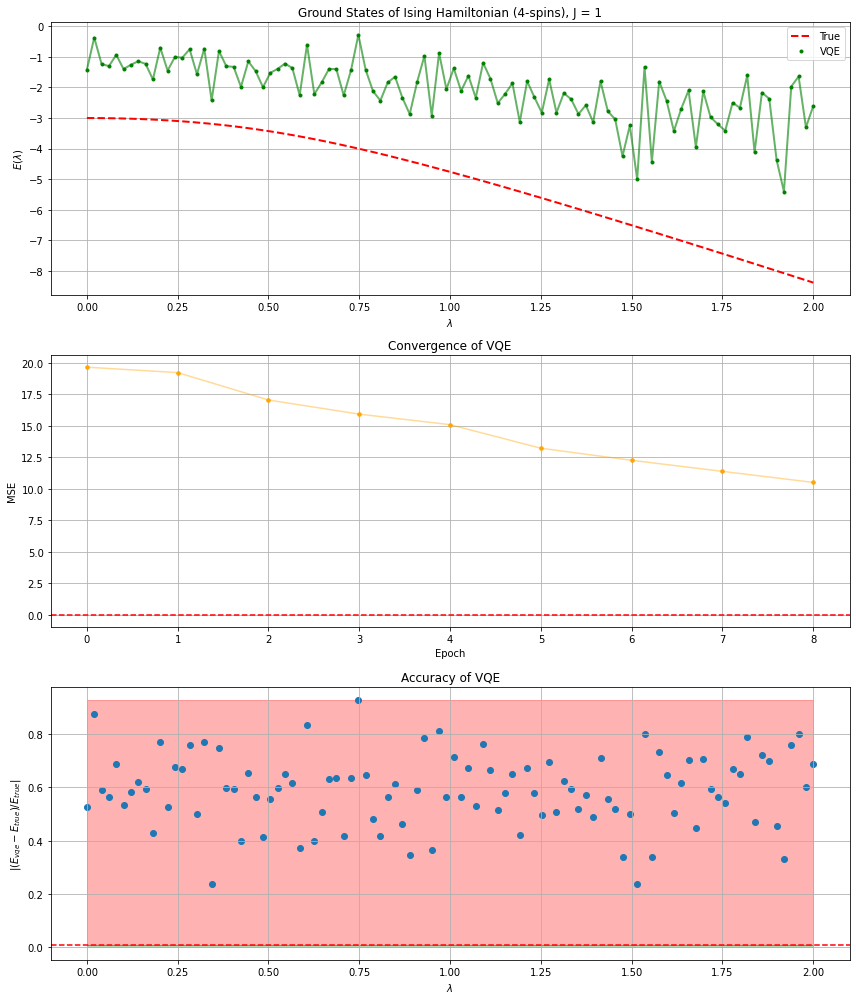

In [66]:
vqe_e, errs, thetas, ys = mptrain(step_size = 0.25, n_epochs = 10, random_shift = 0.005, N = N, J = J, l_steps = 100, vqe_cost_fn = vqe_cost_fn_mixed, 
                                      optimizer = 'SPSA',
                                      shift_invariance = 0, p_noise = 0.005, p_noise_ent = 0.005,
                                      circuit = True, plots = True, prepare_states = False, preplots = True,
                                      prep_step_size = 0.1)

In [3]:
N = 4
J = 1
l_steps = 100
shift_invariance = 0

lams = np.linspace(0,2*J,l_steps)

step_size = 0.03
epochs = 250
shift_invariance = 0

dev_vqe_default = qml.device('default.qubit', wires = N, shots = None)
dev_vqe_mixed   = qml.device("default.mixed", wires = N, shots = None)

@qml.qnode(dev_vqe_default)
def vqe_cost_fn_default(vqe_params, N, shift_invariance, H):
    vqe.circuit(N, vqe_params, shift_invariance)
        
    # return <psi|H|psi>
    return qml.expval(H)

@qml.qnode(dev_vqe_mixed)
def vqe_cost_fn_mixed(vqe_params, N, shift_invariance, H, p_noise = 0, p_noise_ent = 0):
    vqe.circuit(N, vqe_params, shift_invariance, p_noise, p_noise_ent)
        
    # return <psi|H|psi>
    return qml.expval(H)




In [5]:
import vqe_functions as vqe
import qcnn_functions as qcnn
